In [1]:
# Imports
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import tqdm
K.image_data_format()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'channels_last'

In [2]:

DATA_DIR = "C:/Users/Yashwanth/Downloads/Datasets/Doodle_dataset/full_numpy_bitmap_"
IMG_SIZE = 28
label = ["apple", "arm", "banana", "bandage", "baseball", "bat", "blackberry", "bread", "candle", "carrot", "circle", "cloud", "diamond", "door", "elbow", "feather", "foot", "frying pan", "hat", "hexagon", "hockey stick", "key", "knife", "leaf", "octagon", "paintbrush", "star", "triangle", "zigzag"]

In [7]:
# Function to plot 28x28 pixel drawings that are stored in a numpy array.
# Specify how many rows and cols of pictures to display (default 4x5).  
# If the array contains less images than subplots selected, surplus subplots remain empty.
def plot_samples(input_array, rows=1, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [8]:
def preprocessing_data():
    i = 0
    for i in range(len(label)):
        path = DATA_DIR + label[i] + ".npy"
        objectType = np.load(path)
        objectType = np.c_[objectType, (i + 1) * np.ones(len(objectType))]
        plot_samples(objectType, title='Sample arm drawings\n')
        if (i == 0):
            X = objectType[:10000,:-1]
            y = objectType[:10000,-1]
            i += 1
            continue
        # merge the arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
        X = np.concatenate((X, objectType[:10000,:-1]), axis=0).astype('float32') # all columns but the last
        y = np.concatenate((y, objectType[:10000,-1]), axis=0).astype('float32') # the last column
        i += 1
    return X, y

<ipython-input-7-daf0146c8bb2>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(cols,rows))


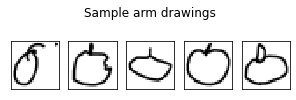

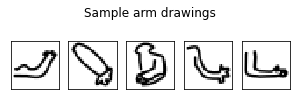

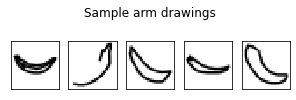

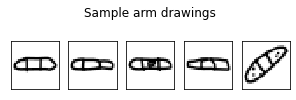

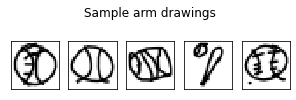

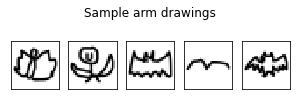

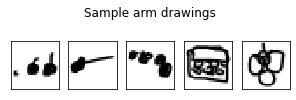

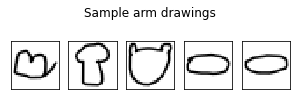

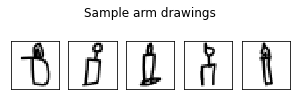

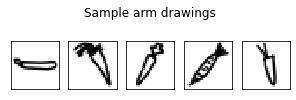

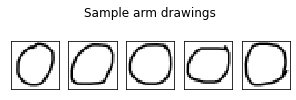

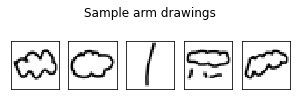

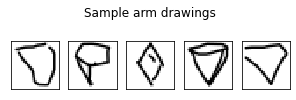

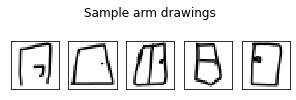

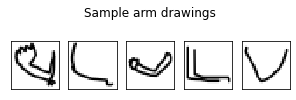

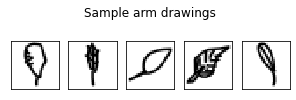

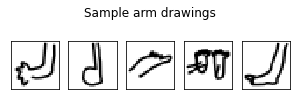

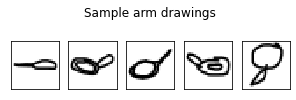

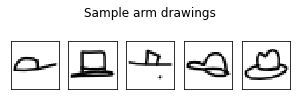

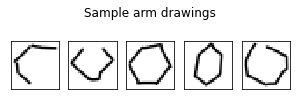

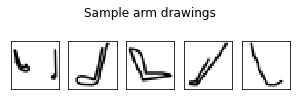

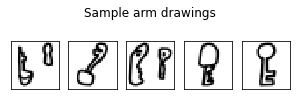

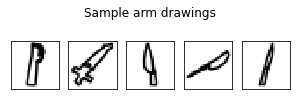

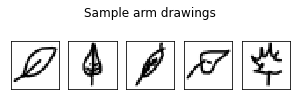

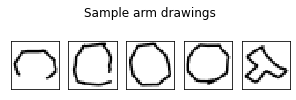

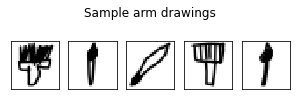

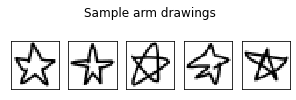

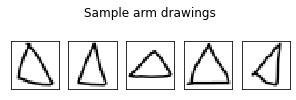

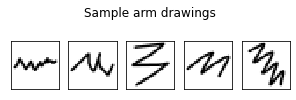

In [9]:
X, y = preprocessing_data()

In [10]:
# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# Use a 50:50 split, training the models on 10'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

In [11]:

# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
s = X_train_cnn.shape
print (s, num_classes)

(145000, 28, 28, 1) 30


In [12]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:

%%time

# build the model
model = cnn_model()
# Fit the model
history = model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=3, batch_size=50)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1]*100, "%")

# Save weights
model.save_weights('quickdraw_neuralnet.h5')
model.save('quickdraw.model')
print("Model is saved")

Epoch 1/3
2900/2900 [==============================] - 84s 24ms/step - loss: 1.6778 - accuracy: 0.5119 - val_loss: 0.8883 - val_accuracy: 0.7455
Epoch 2/3
2900/2900 [==============================] - 63s 22ms/step - loss: 0.8877 - accuracy: 0.7459 - val_loss: 0.7396 - val_accuracy: 0.7904
Epoch 3/3
2900/2900 [==============================] - 64s 22ms/step - loss: 0.7681 - accuracy: 0.7786 - val_loss: 0.6912 - val_accuracy: 0.8026
Final CNN accuracy:  80.26275634765625 %
INFO:tensorflow:Assets written to: quickdraw.model\assets
Model is saved
Wall time: 3min 50s


In [14]:

model = load_model('quickdraw.model')
model.summary()

img_width = 28
img_height = 28

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 375)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

(1, 28, 28, 1)


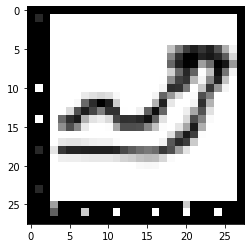

In [19]:

img = cv2.imread('C:/Users/Yashwanth/Downloads/arm.png', 0)

img = cv2.resize(img, (img_width, img_height))
plt.imshow((img.reshape((28,28))), cmap='gray_r')

arr = np.array(img-255)
arr = np.array(arr/255.)

new_test_cnn = arr.reshape(1, 28, 28, 1).astype('float32')
print (new_test_cnn.shape)

In [20]:

# store the label codes in a dictionary
label_dict = {0:"apple", 1:"arm", 2:"banana", 3:"bandage", 4:"baseball", 5:"bat", 6:"blackberry", 7:"bread", 8:"candle", 9:"carrot", 10:"circle", 11:"cloud", 12:"diamond", 13:"door", 14:"elbow", 15:"feather", 16:"foot", 17:"frying pan", 18:"hat", 19:"hexagon", 20:"hockey stick", 21:"key", 22:"knife", 23:"leaf", 24:"octagon", 25:"paintbrush", 26:"star", 27:"triangle", 28:"zigzag"}

# CNN predictions
cnn_probab = model.predict(new_test_cnn, batch_size=32, verbose=0)
print(cnn_probab)
pr = model.predict_classes(arr.reshape((1, 28, 28, 1)))
print(pr - 1)

[[5.5090393e-08 3.9478191e-03 4.9719250e-01 3.3719540e-02 1.0991489e-02
  7.2784103e-03 1.4604634e-02 4.6629668e-03 2.9804513e-02 2.2891071e-03
  1.2609850e-02 5.8485731e-03 8.4823314e-03 4.0593080e-04 1.9044509e-03
  4.4352606e-02 4.2024095e-02 4.5761950e-02 2.0710140e-02 2.1427067e-02
  2.7986502e-03 4.8459237e-03 2.2473620e-02 3.5185821e-02 7.6241076e-02
  3.4205611e-03 3.3173282e-02 1.4163702e-03 4.3447986e-03 8.0818878e-03]]
[2]
